# ICEBERG Fragmentation Analysis (on NIST'20 test dataset)

This notebook provides scripts to plot the analyzed fragmentation data as 3D curves.

In [1]:
import ast
from collections import defaultdict
from typing import Dict, List, Tuple
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from rdkit import Chem
import os
import matplotlib
from ms_pred.common import mass_from_smi
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
import matplotlib.pyplot as plt
from ms_pred.common.plot_utils import set_style

set_style()

In [2]:
%cd ~/ms-pred

/mnt/home/runzhong/ms-pred


## Load data
Data from ICEBERG inference (obtained when running ``run_scripts/iceberg/07_qualitative_analysis.py``).

Please replace `SAVE_PATH` with your custom data from inference.

In [3]:
SAVE_PATH = "results/dag_inten_nist20/split_1_rnd1/qualitative" # NIST'20 test dataset

# LIST OF FILE NAMES is all .csv files in the directory SAVE_PATH
LIST_OF_FILE_NAMES = [f for f in os.listdir(SAVE_PATH) if f.endswith('.csv')]

In [4]:
def load_data(save_path: str, file_name: str) -> pd.DataFrame:
    return pd.read_csv(f"{save_path}/{file_name}")

def load_data_accumulative(save_path: str, file_names: list) -> pd.DataFrame:
    df = pd.DataFrame()

    not_found_files = 0

    for file_name in tqdm(file_names, desc="Loading files", unit="file"):
        try:
            df = pd.concat([df, load_data(save_path, file_name)])
        except FileNotFoundError:
            print(f"File {file_name} not found")
            not_found_files += 1
    print (f"Number of not found files: {not_found_files}")
    
    return df

In [5]:
# Load data -- might take up to an hour to load all files!
data = load_data_accumulative(SAVE_PATH, LIST_OF_FILE_NAMES)
collision_energies = sorted(data['collision_energy'].unique())

Loading files: 100%|██████████████████████████████████████████████████████████████| 2161/2161 [01:27<00:00, 24.61file/s]

Number of not found files: 0


In [6]:
data

,collision_energy,smiles,smarts,mz,intensity,bond_indices,fragment_smarts,complement_smarts
0,5,COc1ccc(N)cc1O,[#6H3]-[#8:9]-[#6:6]1:[#6H:2]:[#6H:1]:[#6:4](:...,80.013090,0.000046,"[(0, 1), (5, 7), (8, 2)]",[#6:1]1:[#6:2]:[#6:6]:[#6:5]:[#6:3]:[#6:4]:1,[#6]-[#8:9].[#7:7].[#8:8]
1,5,COc1ccc(N)cc1O,[#6H3]-[#8:9]-[#6:6]1:[#6H:2]:[#6H:1]:[#6:4](:...,80.013090,0.000008,"[(0, 1), (5, 7), (8, 2)]",[#6:1]1:[#6:2]:[#6:6]:[#6:5]:[#6:3]:[#6:4]:1,[#6]-[#8:9].[#7:7].[#8:8]
2,5,COc1ccc(N)cc1O,[#6H3]-[#8:9]-[#6:6]1:[#6H:2]:[#6H:1]:[#6:4](:...,80.025665,0.000196,"[(5, 6), (5, 7), (8, 2)]",[#6].[#6:1](:[#6:2]):[#6:4]:[#6:3]:[#6:5],[#6:6]-[#8:9].[#7:7].[#8:8]
3,5,COc1ccc(N)cc1O,[#6H3]-[#8:9]-[#6:6]1:[#6H:2]:[#6H:1]:[#6:4](:...,80.025665,0.000158,"[(3, 4), (5, 7), (8, 9)]",[#6].[#6:1]:[#6:2].[#6:3].[#7:7].[#8:8],[#6:4].[#6:5]:[#6:6]-[#8:9]
4,5,COc1ccc(N)cc1O,[#6H3]-[#8:9]-[#6:6]1:[#6H:2]:[#6H:1]:[#6:4](:...,80.025665,0.000077,"[(1, 2), (4, 5), (5, 7)]",[#6:2].[#6:3]:[#6:4]-[#7:7].[#8:8].[#8:9],[#6].[#6:1].[#6:5]:[#6:6]
...,...,...,...,...,...,...,...,...
595,100,Cc1cccc(C)c1NS(C)(=O)=O,[#6H3]-[#6:6]1:[#6H:4]:[#6H:3]:[#6H:5]:[#6:7](...,119.072950,0.137750,"[(8, 9)]",[#6]-[#6:6]1:[#6:4]:[#6:3]:[#6:5]:[#6:7](-[#6:...,[#7:9]-[#16:12](=[#8:10])=[#8:11]
596,100,Cc1cccc(C)c1NS(C)(=O)=O,[#6H3]-[#6:6]1:[#6H:4]:[#6H:3]:[#6H:5]:[#6:7](...,120.080770,0.085478,"[(8, 9)]",[#6]-[#6:6]1:[#6:4]:[#6:3]:[#6:5]:[#6:7](-[#6:...,[#7:9]-[#16:12](=[#8:10])=[#8:11]
597,100,Cc1cccc(C)c1NS(C)(=O)=O,[#6H3]-[#6:6]1:[#6H:4]:[#6H:3]:[#6H:5]:[#6:7](...,120.080770,0.075652,"[(8, 9)]",[#6]-[#6:6]1:[#6:4]:[#6:3]:[#6:5]:[#6:7](-[#6:...,[#7:9]-[#16:12](=[#8:10])=[#8:11]
598,100,Cc1cccc(C)c1NS(C)(=O)=O,[#6H3]-[#6:6]1:[#6H:4]:[#6H:3]:[#6H:5]:[#6:7](...,121.088600,0.017593,"[(8, 9)]",[#6]-[#6:6]1:[#6:4]:[#6:3]:[#6:5]:[#6:7](-[#6:...,[#7:9]-[#16:12](=[#8:10])=[#8:11]


In [7]:
# Filter out rows where row['smiles'] has more than 10 heavay atoms
data = data[data['smiles'].apply(lambda x: len(Chem.MolFromSmiles(x).GetAtoms()) <= 10)]
# show rows where any entry is NaN
data[data.isna().any(axis=1)]

,collision_energy,smiles,smarts,mz,intensity,bond_indices,fragment_smarts,complement_smarts
98,5,COc1ccc(N)cc1O,[#6H3]-[#8:9]-[#6:6]1:[#6H:2]:[#6H:1]:[#6:4](:...,139.062770,0.005603,[],[#6]-[#8:9]-[#6:6]1:[#6:2]:[#6:1]:[#6:4](:[#6:...,NaN
99,5,COc1ccc(N)cc1O,[#6H3]-[#8:9]-[#6:6]1:[#6H:2]:[#6H:1]:[#6:4](:...,140.070600,0.953258,[],[#6]-[#8:9]-[#6:6]1:[#6:2]:[#6:1]:[#6:4](:[#6:...,NaN
198,10,COc1ccc(N)cc1O,[#6H3]-[#8:9]-[#6:6]1:[#6H:2]:[#6H:1]:[#6:4](:...,139.062770,0.009606,[],[#6]-[#8:9]-[#6:6]1:[#6:2]:[#6:1]:[#6:4](:[#6:...,NaN
199,10,COc1ccc(N)cc1O,[#6H3]-[#8:9]-[#6:6]1:[#6H:2]:[#6H:1]:[#6:4](:...,140.070600,0.639343,[],[#6]-[#8:9]-[#6:6]1:[#6:2]:[#6:1]:[#6:4](:[#6:...,NaN
298,20,COc1ccc(N)cc1O,[#6H3]-[#8:9]-[#6:6]1:[#6H:2]:[#6H:1]:[#6:4](:...,139.062770,0.008897,[],[#6]-[#8:9]-[#6:6]1:[#6:2]:[#6:1]:[#6:4](:[#6:...,NaN
...,...,...,...,...,...,...,...,...
198,10,CCN1C(=O)C=CC1=O,[#6H3]-[#6H2:1]-[#7:6]1-[#6:4](-[#6H:2]=[#6H:3...,125.047130,0.000140,[],[#6]-[#6:1]-[#7:6]1-[#6:4](-[#6:2]=[#6:3]-[#6:...,NaN
199,10,CCN1C(=O)C=CC1=O,[#6H3]-[#6H2:1]-[#7:6]1-[#6:4](-[#6H:2]=[#6H:3...,126.054955,0.434402,[],[#6]-[#6:1]-[#7:6]1-[#6:4](-[#6:2]=[#6:3]-[#6:...,NaN
298,20,CCN1C(=O)C=CC1=O,[#6H3]-[#6H2:1]-[#7:6]1-[#6:4](-[#6H:2]=[#6H:3...,125.047130,0.000047,[],[#6]-[#6:1]-[#7:6]1-[#6:4](-[#6:2]=[#6:3]-[#6:...,NaN
299,20,CCN1C(=O)C=CC1=O,[#6H3]-[#6H2:1]-[#7:6]1-[#6:4](-[#6H:2]=[#6H:3...,126.054955,0.112564,[],[#6]-[#6:1]-[#7:6]1-[#6:4](-[#6:2]=[#6:3]-[#6:...,NaN


In [8]:
# drop rows where abs(mz-common.mass_from_smi(row(smiles)) < 1)
data['mass_from_smi'] = data['smiles'].apply(lambda x: mass_from_smi(x))
data['abs_diff'] = abs(data['mz'] - data['mass_from_smi'])
data_new = data[data['abs_diff'] > 1.1]

# remove rows where smiles is CS(=O)(=O)O (this molecule causes issues in fragmentation because no fragmentation is predicted --> all SMARTS are empty)
data_new = data_new[data_new['smiles'] != 'CS(=O)(=O)O']
data_new

/tmp/ipykernel_3856309/1240068073.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mass_from_smi'] = data['smiles'].apply(lambda x: mass_from_smi(x))
/tmp/ipykernel_3856309/1240068073.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['abs_diff'] = abs(data['mz'] - data['mass_from_smi'])


,collision_energy,smiles,smarts,mz,intensity,bond_indices,fragment_smarts,complement_smarts,mass_from_smi,abs_diff
0,5,COc1ccc(N)cc1O,[#6H3]-[#8:9]-[#6:6]1:[#6H:2]:[#6H:1]:[#6:4](:...,80.013090,0.000046,"[(0, 1), (5, 7), (8, 2)]",[#6:1]1:[#6:2]:[#6:6]:[#6:5]:[#6:3]:[#6:4]:1,[#6]-[#8:9].[#7:7].[#8:8],139.063329,59.050239
1,5,COc1ccc(N)cc1O,[#6H3]-[#8:9]-[#6:6]1:[#6H:2]:[#6H:1]:[#6:4](:...,80.013090,0.000008,"[(0, 1), (5, 7), (8, 2)]",[#6:1]1:[#6:2]:[#6:6]:[#6:5]:[#6:3]:[#6:4]:1,[#6]-[#8:9].[#7:7].[#8:8],139.063329,59.050239
2,5,COc1ccc(N)cc1O,[#6H3]-[#8:9]-[#6:6]1:[#6H:2]:[#6H:1]:[#6:4](:...,80.025665,0.000196,"[(5, 6), (5, 7), (8, 2)]",[#6].[#6:1](:[#6:2]):[#6:4]:[#6:3]:[#6:5],[#6:6]-[#8:9].[#7:7].[#8:8],139.063329,59.037664
3,5,COc1ccc(N)cc1O,[#6H3]-[#8:9]-[#6:6]1:[#6H:2]:[#6H:1]:[#6:4](:...,80.025665,0.000158,"[(3, 4), (5, 7), (8, 9)]",[#6].[#6:1]:[#6:2].[#6:3].[#7:7].[#8:8],[#6:4].[#6:5]:[#6:6]-[#8:9],139.063329,59.037664
4,5,COc1ccc(N)cc1O,[#6H3]-[#8:9]-[#6:6]1:[#6H:2]:[#6H:1]:[#6:4](:...,80.025665,0.000077,"[(1, 2), (4, 5), (5, 7)]",[#6:2].[#6:3]:[#6:4]-[#7:7].[#8:8].[#8:9],[#6].[#6:1].[#6:5]:[#6:6],139.063329,59.037664
...,...,...,...,...,...,...,...,...,...,...
595,100,CCN1C(=O)C=CC1=O,[#6H3]-[#6H2:1]-[#7:6]1-[#6:4](-[#6H:2]=[#6H:3...,98.023650,0.000001,"[(0, 1), (5, 6), (6, 7)]",[#6:1].[#6:2](=[#6:3]-[#6:5]=[#8:8])-[#6:4]=[#...,[#6].[#7:6],125.047678,27.024028
596,100,CCN1C(=O)C=CC1=O,[#6H3]-[#6H2:1]-[#7:6]1-[#6:4](-[#6H:2]=[#6H:3...,98.023650,0.000001,"[(0, 1), (5, 6), (6, 7)]",[#6:1].[#6:2](=[#6:3]-[#6:5]=[#8:8])-[#6:4]=[#...,[#6].[#7:6],125.047678,27.024028
597,100,CCN1C(=O)C=CC1=O,[#6H3]-[#6H2:1]-[#7:6]1-[#6:4](-[#6H:2]=[#6H:3...,98.060040,0.000002,"[(3, 4), (5, 6), (6, 7)]",[#6]-[#6:1].[#6:2]=[#6:3]-[#6:5]=[#8:8].[#8:7],[#6:4]-[#7:6],125.047678,26.987638
598,100,CCN1C(=O)C=CC1=O,[#6H3]-[#6H2:1]-[#7:6]1-[#6:4](-[#6H:2]=[#6H:3...,98.060040,0.000002,"[(2, 3), (3, 5)]",[#6]-[#6:1]-[#7:6]-[#6:5]=[#8:8].[#6:2].[#8:7],[#6:3].[#6:4],125.047678,26.987638


## Functions to extract the bond types, atom types and plot the heatmap

In [9]:
def get_bond_type(bond_obj: Chem.Bond) -> str:
    """
    Get the bond type as a string representation.
    
    Args:
        bond_obj (Chem.Bond): The bond object from RDKit.
    
    Returns:
        str: The bond type as a string.
    """
    return {
        Chem.BondType.SINGLE: '-',
        Chem.BondType.DOUBLE: '=',
        Chem.BondType.TRIPLE: '#',
        Chem.BondType.AROMATIC: ':'
    }.get(bond_obj.GetBondType(), '~')

def get_neighbor_info(mol, atom_idx, exclude_idx) -> List[Tuple[str, str, int]]:
    """
    Get information about neighboring atoms of a given atom in the molecule.

    Args:
        mol (Chem.Mol): The RDKit molecule object.
        atom_idx (int): The index of the atom to analyze.
        exclude_idx (int): The index of the atom to exclude from neighbors.

    Returns:
        List[Tuple[str, str, int]]: A list of tuples containing the symbol, bond type, and index of each neighbor.
    """
    neighbors = []
    for bond in mol.GetAtomWithIdx(atom_idx).GetBonds():
        neigh = bond.GetOtherAtom(mol.GetAtomWithIdx(atom_idx))
        if neigh.GetIdx() != exclude_idx and neigh.GetAtomicNum() > 1:
            bond_type = get_bond_type(bond)
            neighbors.append((neigh.GetSymbol(), bond_type, neigh.GetIdx()))
    return sorted(neighbors, key=lambda x: x[2])

def create_bond_string(mol, idx1, idx2, include_env: int = 0) -> str:
    """
    Create a string representation of a bond between two atoms in a molecule.

    Args:
        mol (Chem.Mol): The RDKit molecule object.
        idx1 (int): The index of the first atom.
        idx2 (int): The index of the second atom.
        include_env (int): Flag to include environment information "degree/coordination shere" (0, 1, or 2).

    Returns:
        str: The bond string representation.
    """
    atom1, atom2 = mol.GetAtomWithIdx(idx1), mol.GetAtomWithIdx(idx2)
    symbol1, symbol2 = atom1.GetSymbol(), atom2.GetSymbol()
    bond_type = get_bond_type(mol.GetBondBetweenAtoms(idx1, idx2))
    
    if include_env == 2:
        neighbors1 = get_neighbor_info(mol, idx1, idx2)
        neighbors2 = get_neighbor_info(mol, idx2, idx1)
        
        env1 = ''.join(f"({n[0]}{n[1]})" for n in neighbors1)
        env2 = ''.join(f"({n[0]}{n[1]})" for n in neighbors2)
        
        bond_string1 = f"{env1}{symbol1}{bond_type}{symbol2}{env2}"
        bond_string2 = f"{env2}{symbol2}{bond_type}{symbol1}{env1}"
        return min(bond_string1, bond_string2)
    elif include_env == 1:
        return f"{min(symbol1, symbol2)}{bond_type}{max(symbol1, symbol2)}"
    elif include_env == 0:
        return f"{min(symbol1, symbol2)}~{max(symbol1, symbol2)}"
    else:
        print("Invalid value for include_env. Must be 0, 1, or 2.")

def analyze_bonds(df: pd.DataFrame, include_environment: int = 0) -> Dict[str, Dict[str, float]]:
    """
    Analyzes bonds purely based on fragment and complement SMARTS patterns.
    
    Args:
        df (pd.DataFrame): DataFrame containing the data to analyze.
        include_environment (int): Flag to include environment information "degree/coordination shere" (0, 1, or 2).

    Returns:
        Dict[str, Dict[str, float]]: A dictionary containing the analysis results.
    """
    bond_break_counts = defaultdict(int)          
    bond_intensities = defaultdict(float)         
    bond_occurrences = defaultdict(int)     
    total_break_intensity = 0                     
    max_intensity = 0
    
    # First pass: count total occurrences of each bond type in structures using SMILES
    processed_smiles = set()

    
    from tqdm import tqdm

    for _, row in tqdm(df.iterrows(), total=len(df), desc='First pass'):
        smiles = row.get('smiles', None)
        if smiles and smiles not in processed_smiles:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                continue
                
            processed_smiles.add(smiles)
            
            for bond in mol.GetBonds():
                idx1, idx2 = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
                bond_string = create_bond_string(mol, idx1, idx2, include_env=include_environment)
                bond_occurrences[bond_string] += 1

    # Second pass: analyze fragmentations using fragment comparison
    for _, row in tqdm(df.iterrows(), total=len(df), desc='Second pass'):
        # Get the main molecule structure
        mol = Chem.MolFromSmarts(row['smarts'])
        if mol is None:
            continue
            
        # Get fragment and complement molecules
        fragment_mol = Chem.MolFromSmarts(row['fragment_smarts'])
        try:
            complement_mol = Chem.MolFromSmarts(row['complement_smarts'])
        except:
            complement_mol = None
        
        if fragment_mol is None or complement_mol is None:
            continue
            
        # Get mapped atoms in each part
        fragment_atoms = {atom.GetAtomMapNum() for atom in fragment_mol.GetAtoms() 
                        if atom.GetAtomMapNum() != 0}
        complement_atoms = {atom.GetAtomMapNum() for atom in complement_mol.GetAtoms() 
                        if atom.GetAtomMapNum() != 0}
        
        # For each bond in the main molecule
        for bond in mol.GetBonds():
            begin_atom = bond.GetBeginAtom()
            end_atom = bond.GetEndAtom()
            begin_map = begin_atom.GetAtomMapNum()
            end_map = end_atom.GetAtomMapNum()
            
            # Skip if either atom isn't mapped
            if begin_map == 0 or end_map == 0:
                continue
                
            # Check if this bond crosses between fragment and complement
            if ((begin_map in fragment_atoms and end_map in complement_atoms) or
                (end_map in fragment_atoms and begin_map in complement_atoms)):
                
                # This is a breaking bond!
                bond_string = create_bond_string(mol, bond.GetBeginAtomIdx(), 
                                            bond.GetEndAtomIdx(), include_environment)
                
                bond_break_counts[bond_string] += 1
                bond_intensities[bond_string] += row['intensity']
                total_break_intensity += row['intensity']
                if row['intensity'] > max_intensity:
                    max_intensity = row['intensity']

    total_structural_bonds = sum(bond_occurrences.values())
    total_breaks = sum(bond_break_counts.values())
    
    normalized_intensities = {
        bond: intensity / bond_occurrences.get(bond, 1)
        for bond, intensity in bond_intensities.items()
    }
    
    total_normalized_intensity = sum(normalized_intensities.values())
    
    # Which bonds are intrinsically most likely to break, regardless of how many times they appear in the structure?
    # P-score = normalized intensity contribution per unique bond occurrence
    preferential_score = {
        bond: (norm_intensity / total_normalized_intensity) * 100
        for bond, norm_intensity in normalized_intensities.items()
    }

    # In this implementation, we exclusively show the preferential score (pScore).
    return {
        'preferential_score': dict(preferential_score),
        'bond_occurences': dict(bond_occurrences),
    }

def prepare_data(data, analyze_bonds_func, metrics_to_look_at):
    """
    Prepares data for analysis by grouping it by collision energy and analyzing bonds.
    
    Args:
        data (pd.DataFrame): The input data to analyze.
        analyze_bonds_func (function): The function to analyze bonds.
        metrics_to_look_at (list): List of metrics to include in the analysis.
        
    Returns:
        Tuple[Dict[str, pd.DataFrame], List[float], List[str]]: A tuple containing:
        - A dictionary of DataFrames for each metric.
        - A list of unique collision energies.
        - A list of unique bond types.
        
    """
    collision_energies = sorted(data['collision_energy'].unique())
    
    # First get all results for each collision energy
    all_results = {ce: analyze_bonds_func(data[data['collision_energy'] == ce]) 
                  for ce in collision_energies}
    
    # Get ALL bond types from bond_occurences
    all_bond_types = set()
    for result in all_results.values():
        all_bond_types.update(result['bond_occurences'].keys())
        # Also include bond types from other metrics if needed
        if 'bond_occurences' not in metrics_to_look_at:
            for metric in metrics_to_look_at:
                all_bond_types.update(result[metric].keys())
    
    # Create DataFrames
    result_dfs = {}
    for result_type in metrics_to_look_at:
        # For other metrics, keep original behavior
        df_data = {ce: {bt: 0.0 for bt in all_bond_types} 
                    for ce in collision_energies}
        
        for ce, result in all_results.items():
            for bt, value in result[result_type].items():
                df_data[ce][bt] = value
        
        result_dfs[result_type] = pd.DataFrame(df_data).T
    
    return result_dfs, collision_energies, list(sorted(all_bond_types))


def plot_3d_by_bond(grouped_data, collision_energies, bond_types, result_type,
                    cmap='viridis', figsize=(12,8)):
    # ---- prepare display_data as before ----
    display_data = (grouped_data[bond_types]
                    .sort_index()
                    .fillna(0))

    display_data = display_data.div(display_data.sum(axis=1), axis=0) * 100

    # numeric arrays
    #Y = np.array(collision_energies, dtype=float)    # now the vertical axis
    Y = np.arange(len(collision_energies))
    n_e, n_b = display_data.shape                    # (#energies, #bonds)

    # X axis will be just integer indices for each bond type
    X_idx = np.arange(n_b)

    fig = plt.figure(figsize=figsize, dpi=400)
    ax  = fig.add_subplot(111, projection='3d')

    # set up your axes ticks & labels
    ax.set_xticks(X_idx)
    ax.set_xticklabels(display_data.columns)
    ax.set_yticks(Y)
    ax.set_yticklabels(collision_energies)
    ax.set_xlabel('Bond type')
    ax.set_ylabel('Collision energy (eV)')
    ax.set_zlabel('Average contribution\nto intensity (%)')
    ax.xaxis.labelpad=-3
    ax.yaxis.labelpad=-3
    ax.zaxis.labelpad=-3

    # color normalization over bond types
    norm      = plt.Normalize(0, n_b - 1)
    cmap_inst = plt.get_cmap(cmap)

    # for each bond type, build and draw its "curtain" + top edge
    for i, bond in enumerate(display_data.columns):
        zs = display_data[bond].values
        xs = np.full_like(Y, i, dtype=float)

        # build the “curtain” polygon
        top    = np.column_stack((xs,       Y,       zs))
        bottom = np.column_stack((xs[::-1], Y[::-1], np.zeros_like(zs)))
        verts  = np.vstack((top, bottom))

        poly = Poly3DCollection([verts], alpha=0.2)
        color = cmap_inst(norm(i))
        poly.set_facecolor(color)
        poly.set_edgecolor('none')
        ax.add_collection3d(poly)

        # draw its 3D line on top
        ax.plot(xs, Y, zs, color=color, linewidth=0.8)

    plt.tight_layout()
    plt.show()
    fig.savefig('preferential.pdf', bbox_inches="tight")

## Plot bond-breaking frequency (Ext Data Fig 3)

Give scores for environments such as C-C, C:C, C=O, ...

In [10]:
# 3D plotting without environment
data_frames_1, collision_energies_1, bond_types_1 = prepare_data(data, lambda df: analyze_bonds(df, include_environment=1), metrics_to_look_at=['preferential_score', 'bond_occurences'])

Second pass: 100%|██████████████████████████████████████████████████████████████| 17900/17900 [00:14<00:00, 1262.67it/s]


/tmp/ipykernel_3856309/83397537.py:282: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


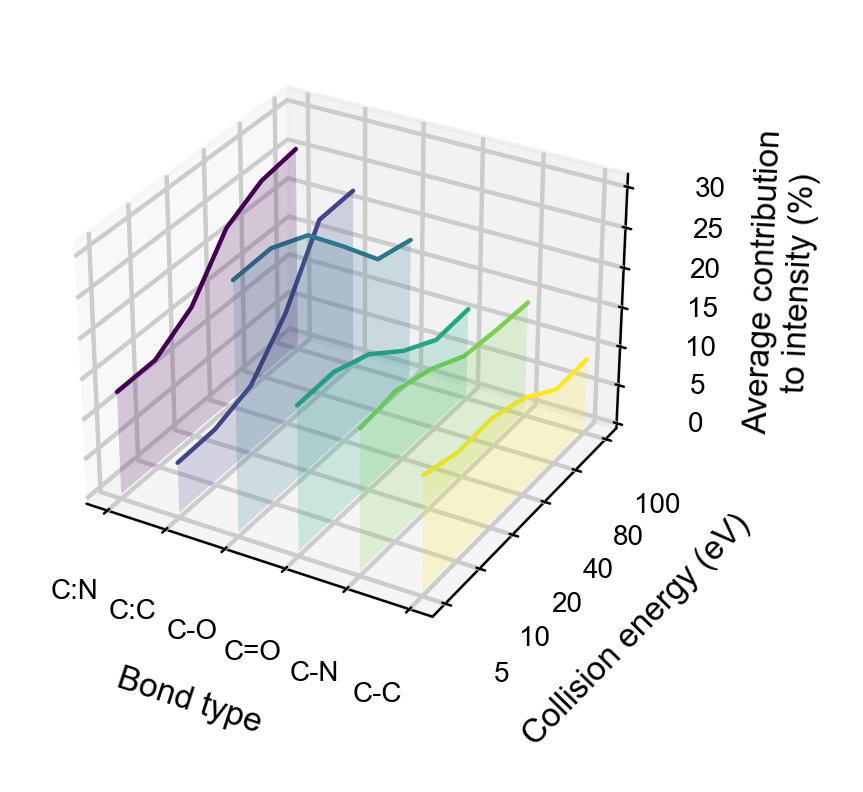

In [11]:
plot_3d_by_bond(data_frames_1['preferential_score'], collision_energies_1, ['C:N', 'C:C', 'C-O', 'C=O', 'C-N', 'C-C'], 'preferential_score', cmap='viridis', 
                figsize=(2,2))